In [4]:
# !python -m venv env 
# !python -m pip install --upgrade pip
# !pip install tensorflow
# !pip install -U imbalanced-learn
# !pip install sklearn
# !pip install mediapipe
# !pip install opencv-python


### (Opcional) Redimensionar imágenes 

In [4]:
import cv2
import os

input_folder = "./classes_poses/"
output_folder = "./classes_poses_red/"
new_size = (224, 224)

for root, dirs, files in os.walk(input_folder):
    relative_path = os.path.relpath(root, input_folder)
    output_subfolder = os.path.join(output_folder, relative_path)
    os.makedirs(output_subfolder, exist_ok=True)
    for file in files:
        input_path = os.path.join(root, file)
        output_path = os.path.join(output_subfolder, file)
        img = cv2.imread(input_path)
        resized_img = cv2.resize(img, new_size)
        cv2.imwrite(output_path, resized_img)

## Grafico de una seña para cada clase

Matplotlib is building the font cache; this may take a moment.


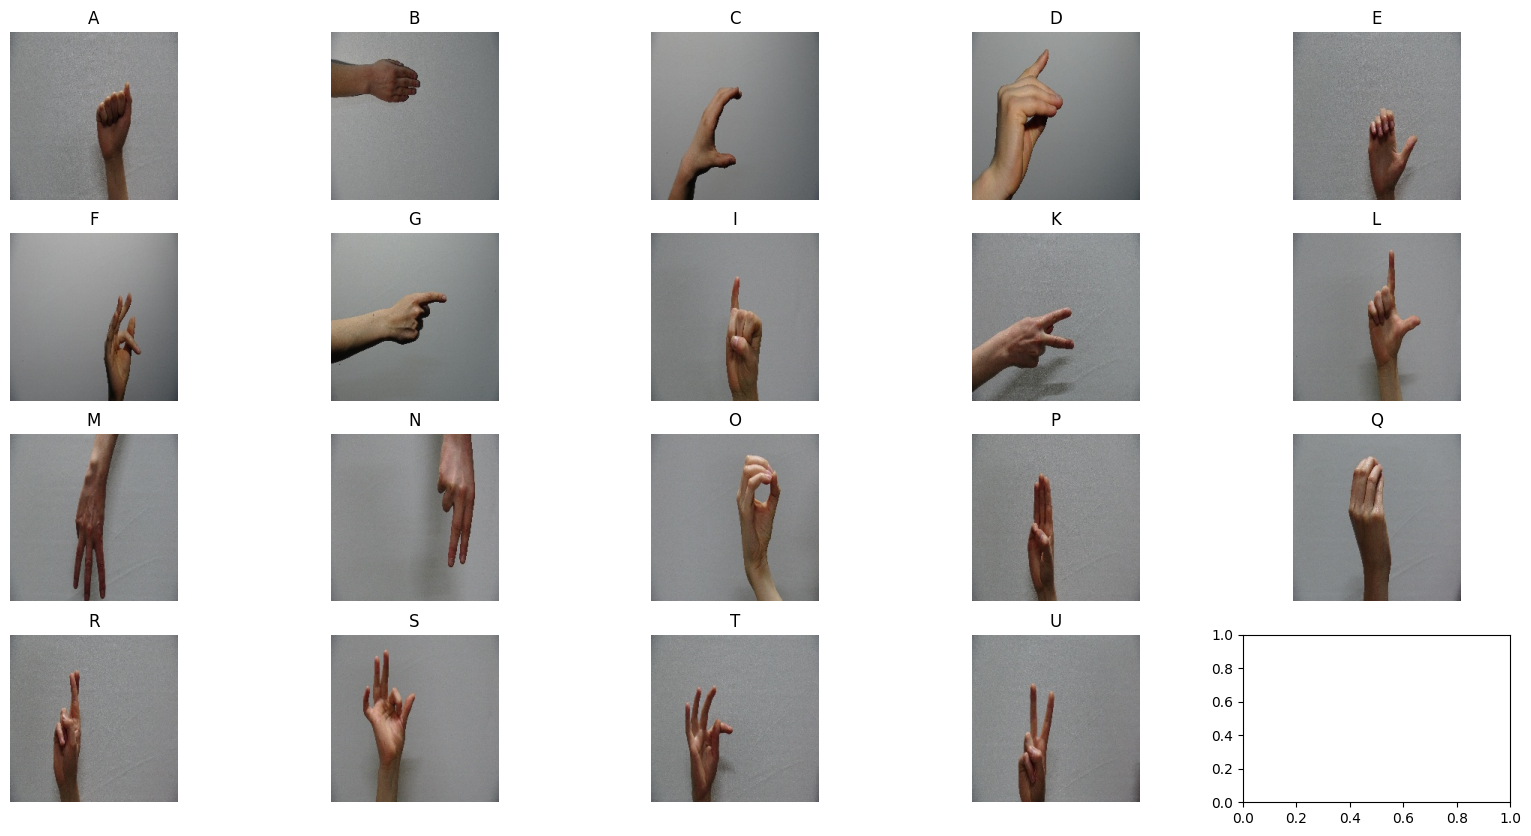

In [5]:
import matplotlib.pyplot as plt
import os
import random
from matplotlib import image as mpimg
import json

class_indices = json.load(open('class_indices.json'))
classes = list(class_indices.keys())
fig, axes = plt.subplots(4, 5, figsize=(20, 10))

for i in range(min(len(classes), 19)):
    class_name = classes[i]
    img_name = random.choice(os.listdir(f'./classes/{class_name}'))
    img_path = f'./classes/{class_name}/{img_name}'
    
    img = mpimg.imread(img_path)
    
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].set_title(class_name)
    axes[i // 5, i % 5].axis('off')

plt.show()


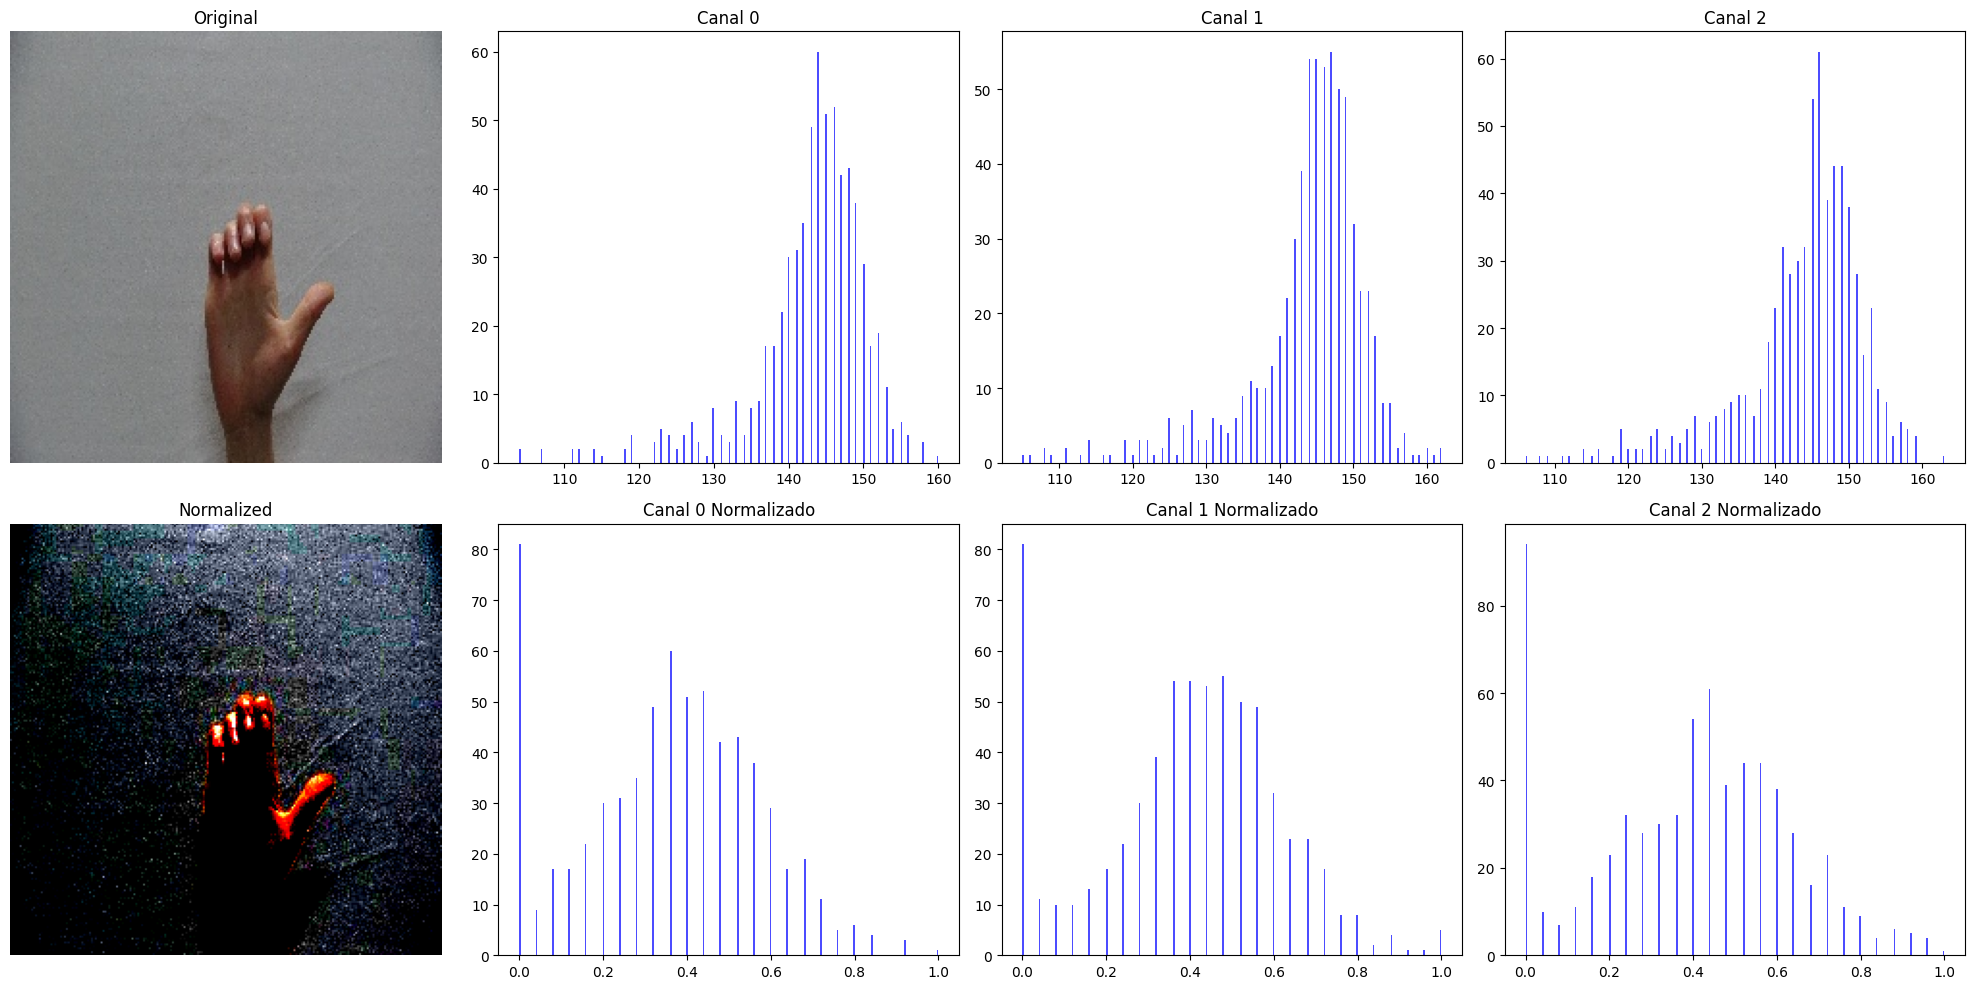

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def plot_histogram(ax, channel, title):
    ax.hist(channel.ravel(), bins=256, color='blue', alpha=0.7)
    ax.set_title(title)

img = cv2.imread("./classes/E/DSC02287.JPG")
    
###############################################
# cap = cv2.VideoCapture(0)
# while True:
#     ret, img = cap.read()
#     if not ret:
#         break
#     cv2.imshow('Video', img)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()
###############################################
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# print(img.shape)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

axes[0, 0].imshow(img)
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

# Plot histograms before normalization
for i in range(3):
    channel = img[i]
    plot_histogram(axes[0, i + 1], channel, f'Canal {i}')

# Normalize the image
img_normalized = np.zeros_like(img, dtype=np.float32)


channel = img / 255  # Scale channel values to [0, 1]
channel_med = np.median(channel)  # Calculate the median value
channel_std = np.std(channel)  # Calculate the standard deviation

# Apply the normalization formula
if channel_std > 0:
    img_normalized= (channel - channel_med) / channel_std
else:
    img_normalized = 0

# Clip values to the valid range [0, 1] for display
img_normalized = np.clip(img_normalized, 0, 1)

axes[1, 0].imshow(img_normalized)
axes[1, 0].set_title('Normalized')
axes[1, 0].axis('off')

# Plot histograms after normalization
for i in range(3):
    channel_normalized = img_normalized[i]
    plot_histogram(axes[1, i + 1], channel_normalized, f'Canal {i} Normalizado')

plt.tight_layout()
plt.show()


## Normalizacion en tiempo real

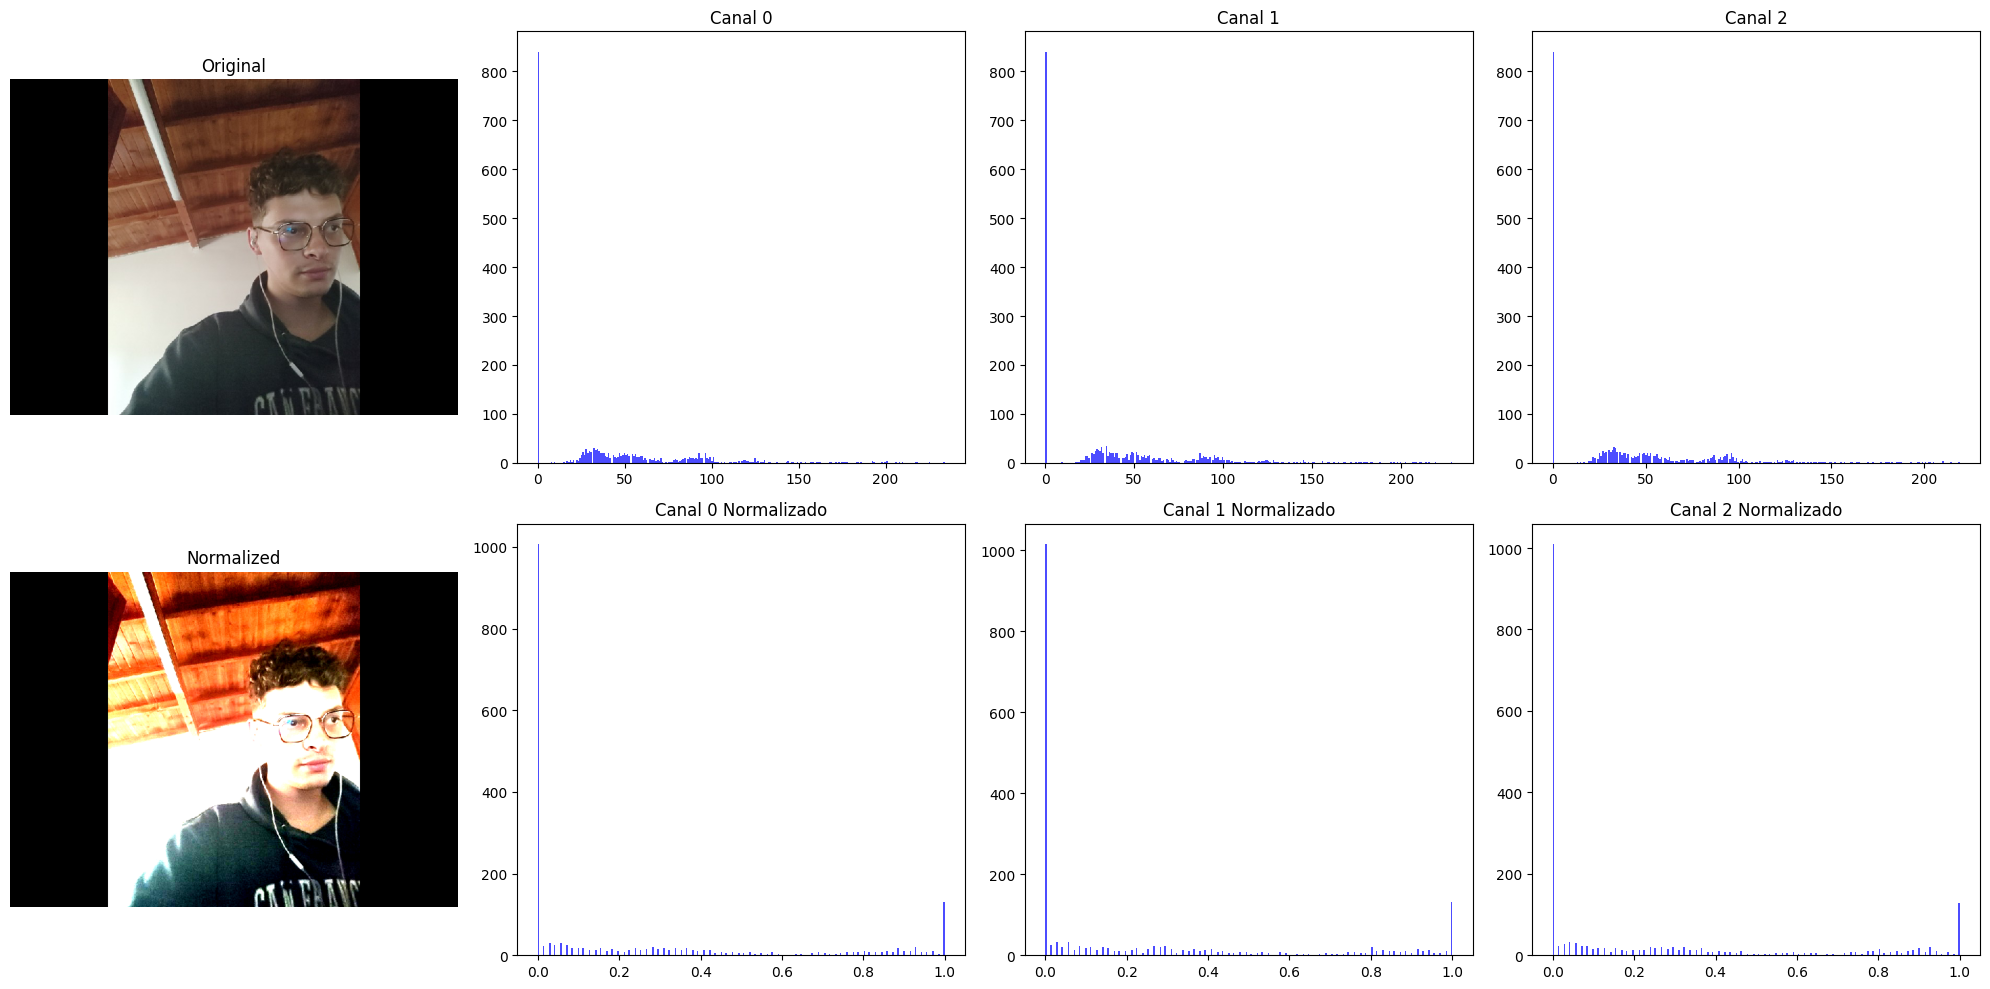

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def plot_histogram(ax, channel, title):
    ax.hist(channel.ravel(), bins=256, color='blue', alpha=0.7)
    ax.set_title(title)

def calculate_histogram(channel):
    hist = cv2.calcHist([channel], [0], None, [256], [0, 256])
    return hist


cap = cv2.VideoCapture(0)

while True:
    _, frame = cap.read()

    if frame is None:
        break


    # frame = 
    
    frame_ = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR) 
    
    cv2.imshow("Frame", np.concatenate((frame, frame_), axis=0) )


    if cv2.waitKey(1) & 0xFF == ord('q'):

        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        axes[0, 0].imshow(frame_)
        axes[0, 0].set_title('Original')
        axes[0, 0].axis('off')

        # Plot histograms before normalization
        for i in range(3):
            channel = frame_[i]
            plot_histogram(axes[0, i + 1], channel, f'Canal {i}')

        # Normalize the image
        frame_normalized = np.zeros_like(frame_, dtype=np.float32)


        channel = frame_ / 255  # Scale channel values to [0, 1]
        channel_med = np.median(channel)  # Calculate the median value
        channel_std = np.std(channel)  # Calculate the standard deviation

        # Apply the normalization formula
        if channel_std > 0:
            frame_normalized= (channel - channel_med) / channel_std
        else:
            frame_normalized = channel

        # Clip values to the valid range [0, 1] for display
        frame_normalized = np.clip(frame_normalized, 0, 1)

        axes[1, 0].imshow(frame_normalized)
        axes[1, 0].set_title('Normalized')
        axes[1, 0].axis('off')

        # Plot histograms after normalization
        for i in range(3):
            channel_normalized = frame_normalized[i]
            plot_histogram(axes[1, i + 1], channel_normalized, f'Canal {i} Normalizado')

        plt.tight_layout()
        plt.show()
        break

cap.release()
cv2.destroyAllWindows()




## Definición de los estimadores de pose

restarle a cada canart por separado la media del canal y dividir por la desviación estandar, garantizo ma media de o y desviacion estandar de 1

tener canal el grises
aumentar el tamaño de lo spuntos y grosor del as lineas 
adquirir criterios para seleccionar los parametros


## Crear Dataset de poses redimensionadas


In [12]:
import cv2
import mediapipe as mp
import numpy as np
import os
import time

def draw_hand_landmarks(frame, landmarks, COLOR):
    height, width, _ = frame.shape
    # frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    x_min, y_min, x_max, y_max = width, height, 0, 0
    
    for i, point in enumerate(landmarks.landmark):
        x, y = int(point.x * width), int(point.y * height)
        color = (0, 255, 0) if i % 4 == 0 else (0, 0, 255)
        cv2.circle(frame, (x, y), int(height * 0.01), color, -1)
        
        # Actualizar las coordenadas mínimas y máximas para dibujar un rectángulo alrededor de la mano
        x_min = min(x_min, x)
        y_min = min(y_min, y)
        x_max = max(x_max, x)
        y_max = max(y_max, y)

    connections = [[0, 1], [1, 2], [2, 3], [3, 4], [0, 5], 
                   [5, 6], [6, 7], [7, 8], [0, 9], [9, 10], 
                   [10, 11], [11, 12], [0, 13], [13, 14], [14, 15], 
                   [15, 16], [0, 17], [17, 18], [18, 19], [19, 20]]
    
    for connection in connections:
        cv2.line(frame, (int(landmarks.landmark[connection[0]].x * width), int(landmarks.landmark[connection[0]].y * height)),
                         (int(landmarks.landmark[connection[1]].x * width), int(landmarks.landmark[connection[1]].y * height)), COLOR, 2)
    
    # Dibujar un rectángulo alrededor de la mano
    # cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (255, 0, 255), 2)
    return frame, (x_min-15, y_min-15, x_max+15, y_max+15)

def capture_frames(period, folder, num_frames):
    # crear carpeta de clases
    if not os.path.exists(folder):
        os.makedirs(folder)

    letters = ["A", "B", "C", "D", "E", "F", "G", "I", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U"]

    # crear subcarpetas para cada letra del alfabeto
    for letter in letters:
        letter_folder = os.path.join(folder, letter)
        if not os.path.exists(letter_folder):
            os.makedirs(letter_folder)

    cap = cv2.VideoCapture(0) # Inicializar la cámara
    count = 0 # Contador para capturar frames
    letter_idx = 0 # Índice de la letra actual
    frames_taken = 0 # Contador para el número de frames tomados por letra

    while True:
        ret, frame = cap.read() # Leer un frame de la cámara

        # Si no se pudo leer el frame, terminar el ciclo
        if not ret:
            print("Error al leer el frame")
            break

        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # Convertir el frame de BGR a RGB

        hands_results = hands.process(img) # Procesar el frame con el modelo de manos
        black_frame = np.zeros_like(frame) # Crear una imagen negra del mismo tamaño que el frame

        # Dibujar puntos y líneas para las manos en la imagen negra
        if hands_results.multi_hand_landmarks:
            for landmarks in hands_results.multi_hand_landmarks:
                drawn_frame, hand_rect = draw_hand_landmarks(frame, landmarks, (0, 0, 255)) # Dibujar puntos y líneas para las manos
                # Guardar el frame en la carpeta correspondiente
                if count % period == 0 and frames_taken < num_frames:
                    letter = letters[letter_idx] # Obtener la letra actual
                    letter_folder = os.path.join(folder, letter) # Obtener la carpeta correspondiente a la letra
                    try: 
                        frame_resized = cv2.resize(drawn_frame[hand_rect[1]:hand_rect[3], hand_rect[0]:hand_rect[2]], (512, 512)) # Redimensionar el frame
                        cv2.imwrite(os.path.join(letter_folder, f"{time.time()}.jpg"), cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY)) # Guardar el frame en la carpeta
                        frames_taken += 1 # Incrementar el contador de frames tomados por letra
                        count = 0 # Reiniciar el contador
                    except: 
                        pass
                if frames_taken >= num_frames:
                    frames_taken = 0 # Reiniciar el contador de frames tomados por letra
                    letter_idx = (letter_idx + 1) % len(letters) # Cambiar a la siguiente letra
                count += 1

       
        cv2.putText(frame, f'Letra: {letters[letter_idx]}', (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        cv2.putText(frame, f'Capturas: {frames_taken}', (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2) 
        cv2.imshow('Pose Detection', frame) # Mostrar el frame con las manos detectadas
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break # Si se presiona la tecla 'q', terminar el ciclo

    cap.release() # Liberar la cámara
    cv2.destroyAllWindows() # Cerrar todas las ventanas
    hands.close() # Cerrar el modelo de manos

mp_hands = mp.solutions.hands # Importar el modelo de manos de MediaPipe
hands = mp_hands.Hands() # Inicializar el modelo de manos

capture_frames(15, "classes_poses_cut", 100) # Capturar frames cada 5 frames y guardar 20 frames por letra
